<div class="alert alert-success">  
    <h1 align="center" style="color:darkcyan;">Explore Multi-Label Classification with an Enzyme Substrate Dataset</h1>  
    <h1 align="center" style="color:darkred;">Via GaussianNB</h1>  
    <h3 align="center" style="color:gray;">Playground Series - Season 3, Episode 18</h3>    
</div>

<div class="alert alert-success">  
</div>

In [1]:
import warnings # suppress warnings
warnings.filterwarnings('ignore')
#########################################
import os
import gc
import glob
import random
import numpy as np 
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy import stats
from pathlib import Path
#########################################
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.express as px
%matplotlib inline
!ls ../input/*
#########################################
pd.set_option('display.max_columns', 500)

sample_submission.csv  test.csv  train.csv


In [2]:
df_train  = pd.read_csv('../input/playground-series-s3e18/train.csv', index_col='id')
df_test   = pd.read_csv('../input/playground-series-s3e18/test.csv', index_col='id')
df_sample = pd.read_csv('../input/playground-series-s3e18/sample_submission.csv')

# df_train.describe().transpose()
# display(df_train , df_test, df_sample)
df_train.shape , df_test.shape, df_sample.shape

((14838, 37), (9893, 31), (9893, 3))

In [3]:
# df_train = pd.concat([df_train, df_org], axis = 0).reset_index(drop=True)
# df_train.shape

<div class="alert alert-success">  
</div>

## <span style="color:darkred;">Check Null Values</span>

In [4]:
MV1 = df_train.isnull().sum()
MV2 = df_test.isnull().sum()

print(':' * 25)
print(f'Missing Value df_train:\n{MV1[MV1 > 0]}')
print(':' * 25)
print(f'Missing Value df_test:\n{MV2[MV2 > 0]}')
print(':' * 25)

:::::::::::::::::::::::::
Missing Value df_train:
Series([], dtype: int64)
:::::::::::::::::::::::::
Missing Value df_test:
Series([], dtype: int64)
:::::::::::::::::::::::::


## <span style="color:darkred;">Check Duplicates</span>

In [5]:
df_train.duplicated().value_counts()

False    14838
dtype: int64

In [6]:
df_test.duplicated().value_counts()

False    9893
dtype: int64

In [7]:
df_train = df_train.drop_duplicates()
df_train.shape

(14838, 37)

## <span style="color:darkred;">Train | Test | Target</span>

In [8]:
col = [c for c in df_train.columns.tolist() if c not in df_test.columns.tolist()]
col 

['EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6']

In [9]:
df_sample.columns.tolist()

['id', 'EC1', 'EC2']

In [10]:
test = df_test.copy()
train = df_train.drop(columns=col)
target = df_train[['EC1','EC2']]

train.shape , test.shape, target.shape

((14838, 31), (9893, 31), (14838, 2))

## <span style="color:darkred;">Target graph</span>

,,Number,Percent
EC1,EC2,,
1,1,7507,0.505931
0,1,4348,0.293031
1,0,2401,0.161814
0,0,582,0.039224


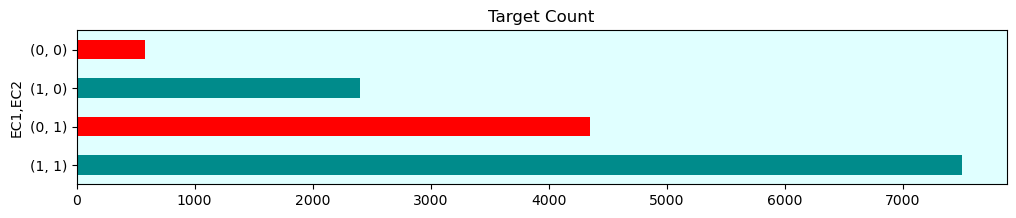

In [11]:
target.value_counts().plot(kind='barh', figsize=(12,2), title='Target Count', color=['darkcyan','red'])
plt.gca().set_facecolor('lightcyan')

pd.DataFrame(data= {'Number': target.value_counts(), 'Percent': target.value_counts(normalize=True)})

## <span style="color:darkred;">All Features</span>

In [12]:
features = train.columns.tolist()
len(features)

31

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14838 entries, 0 to 14837
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   BertzCT            14838 non-null  float64
 1   Chi1               14838 non-null  float64
 2   Chi1n              14838 non-null  float64
 3   Chi1v              14838 non-null  float64
 4   Chi2n              14838 non-null  float64
 5   Chi2v              14838 non-null  float64
 6   Chi3v              14838 non-null  float64
 7   Chi4n              14838 non-null  float64
 8   EState_VSA1        14838 non-null  float64
 9   EState_VSA2        14838 non-null  float64
 10  ExactMolWt         14838 non-null  float64
 11  FpDensityMorgan1   14838 non-null  float64
 12  FpDensityMorgan2   14838 non-null  float64
 13  FpDensityMorgan3   14838 non-null  float64
 14  HallKierAlpha      14838 non-null  float64
 15  HeavyAtomMolWt     14838 non-null  float64
 16  Kappa3             148

In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9893 entries, 14838 to 24730
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   BertzCT            9893 non-null   float64
 1   Chi1               9893 non-null   float64
 2   Chi1n              9893 non-null   float64
 3   Chi1v              9893 non-null   float64
 4   Chi2n              9893 non-null   float64
 5   Chi2v              9893 non-null   float64
 6   Chi3v              9893 non-null   float64
 7   Chi4n              9893 non-null   float64
 8   EState_VSA1        9893 non-null   float64
 9   EState_VSA2        9893 non-null   float64
 10  ExactMolWt         9893 non-null   float64
 11  FpDensityMorgan1   9893 non-null   float64
 12  FpDensityMorgan2   9893 non-null   float64
 13  FpDensityMorgan3   9893 non-null   float64
 14  HallKierAlpha      9893 non-null   float64
 15  HeavyAtomMolWt     9893 non-null   float64
 16  Kappa3             

In [15]:
pd.DataFrame(data= {'Train': train.nunique(), 'Test': test.nunique()})

,Train,Test
BertzCT,2368,1811
Chi1,1259,1047
Chi1n,3157,2473
Chi1v,3306,2604
Chi2n,3634,2806
Chi2v,3725,2858
Chi3v,3448,2644
Chi4n,2930,2249
EState_VSA1,719,582
EState_VSA2,445,380


## <span style="color:darkred;">Categorical Features</span>

In [16]:
cat_features = [f for f in features if train[f].dtype==int]
cat_features

['NumHeteroatoms', 'fr_COO', 'fr_COO2']

In [17]:
s_train1 = set(train['NumHeteroatoms'])
s_test1 = set(test['NumHeteroatoms'])
up1 = list(set(s_train1.union(s_test1)))

print(len(s_train1) == len(up1))
print(len(up1))

False
44


In [18]:
s_train2 = set(train['fr_COO'])
s_test2 = set(test['fr_COO'])
up2 = list(set(s_train2.union(s_test2)))

print(len(s_train2) == len(up2))
print(len(up2))

False
9


In [19]:
s_train3 = set(train['fr_COO2'])
s_test3 = set(test['fr_COO2'])
up3 = list(set(s_train3.union(s_test3)))

print(len(s_train3) == len(up3))
print(len(up3))

False
9


#### So there is a problem in all three "Categorical Features". We will solve this problem when we do "OneHotEncoder".

## <span style="color:darkred;">Numerical Features</span>

In [20]:
num_features = [f for f in features if f not in cat_features]
len(num_features)

28

<div class="alert alert-success">  
</div>

## <span style="color:darkred;">Histograms of the Features</span>

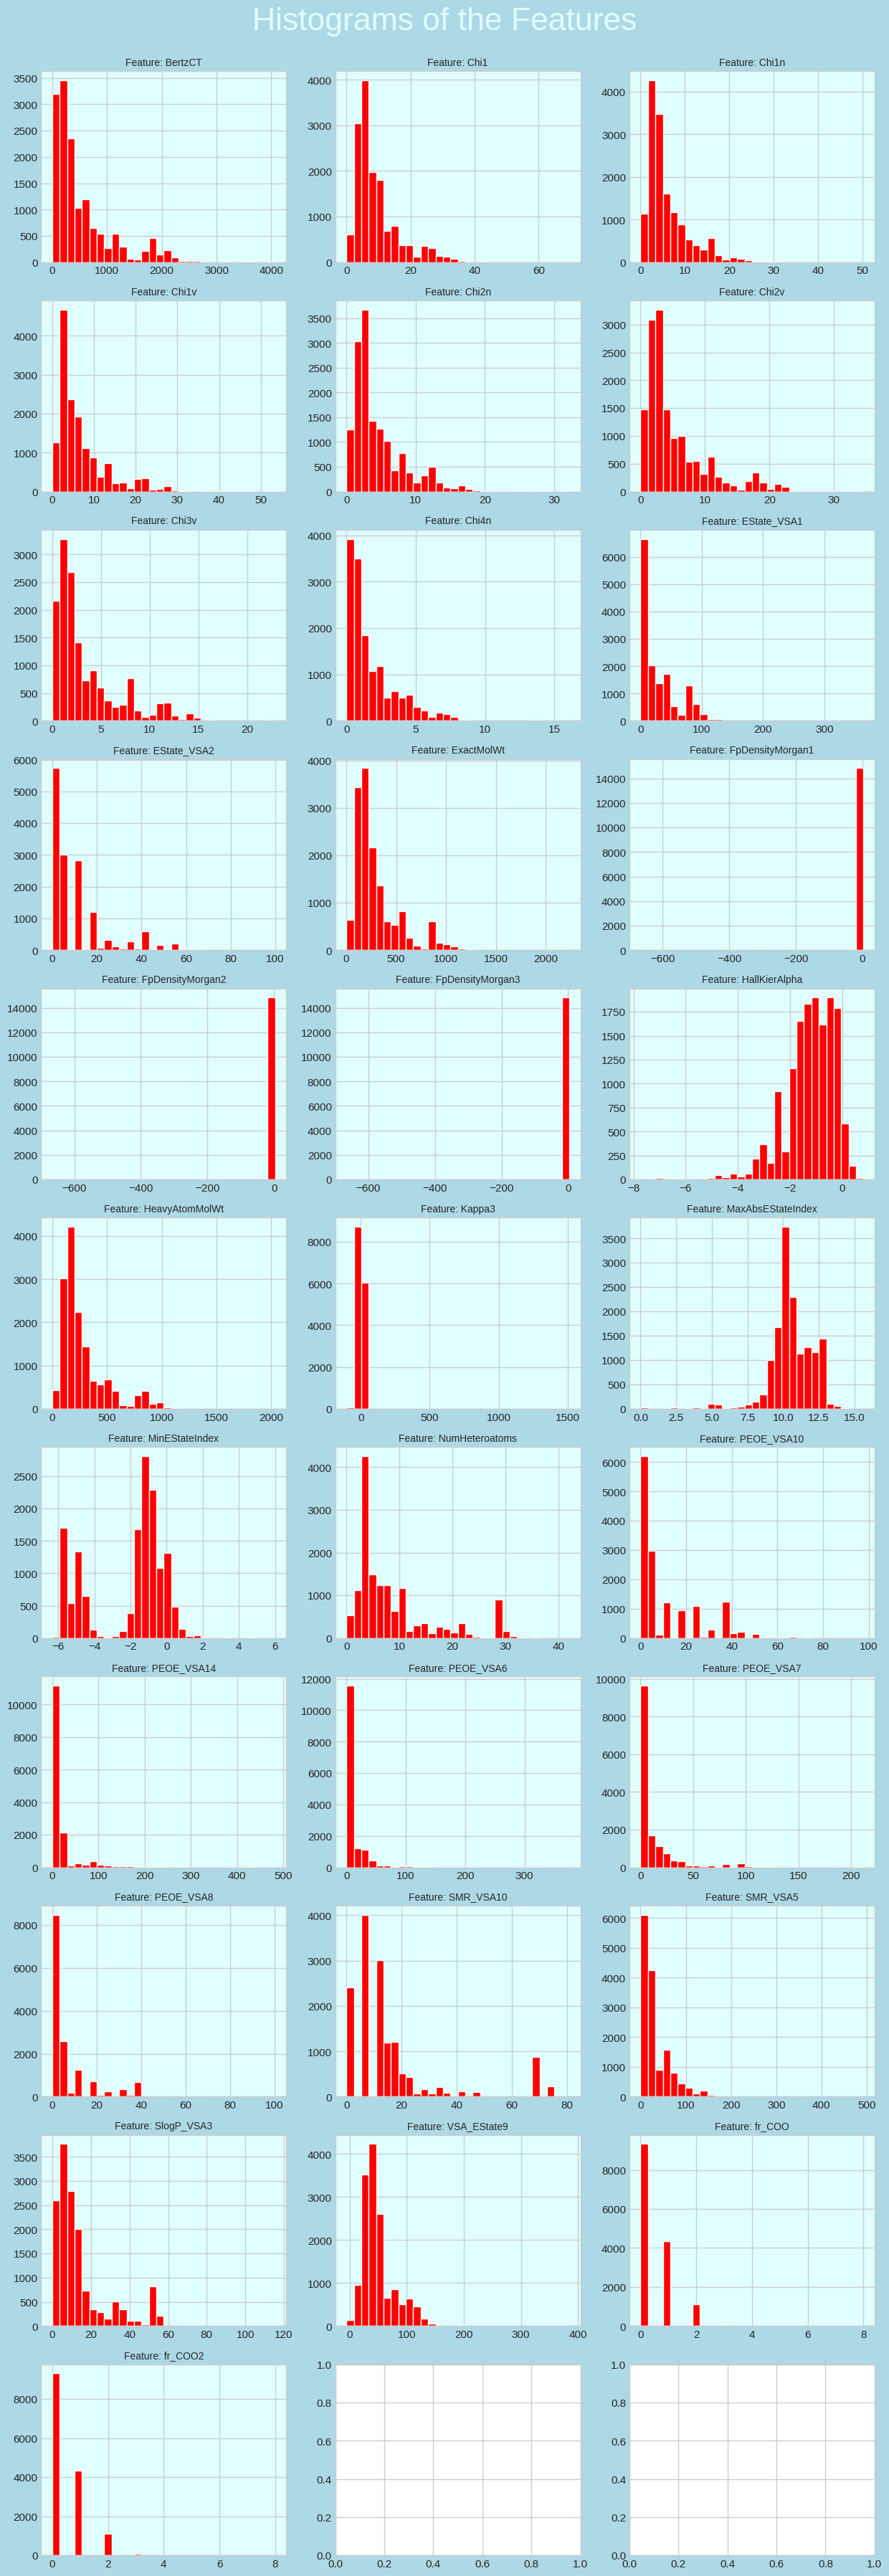

In [21]:
sns.set()
plt.style.use('seaborn-whitegrid') 
_, axs = plt.subplots(11, 3, figsize=(15,45), facecolor='lightblue')

for f, ax in zip(features, axs.ravel()):
    ax.set_facecolor('lightcyan')
    ax.hist(train[f], bins=30, color='red')
    ax.set_title(f'Feature: {f}', fontsize=10)

plt.suptitle('Histograms of the Features', y=0.90, fontsize=32, color='lightcyan')
plt.show()

<div class="alert alert-success">  
</div>

## <span style="color:darkred;">Correlation Matrix</span>

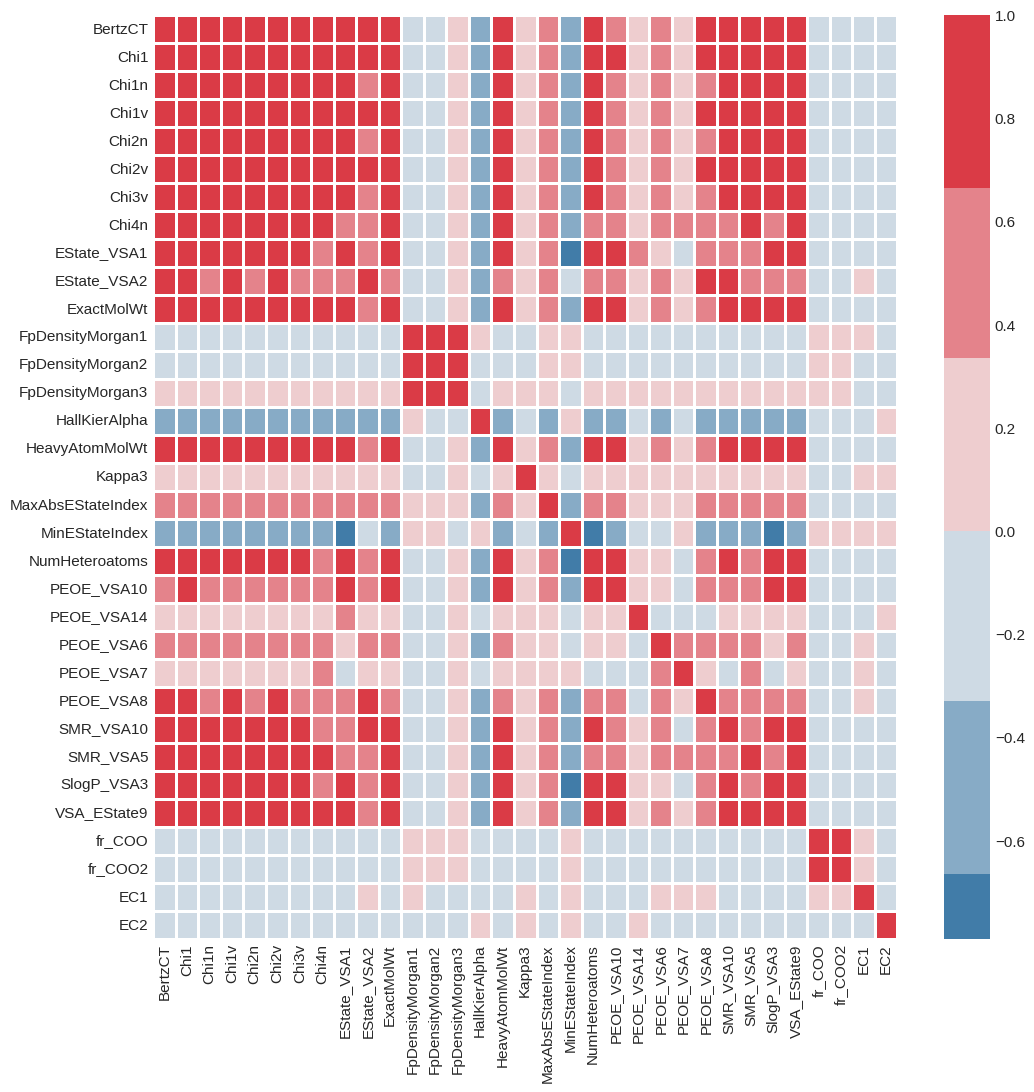

In [22]:
cor_matrix = df_train[features + ['EC1','EC2']].corr()
fig = plt.figure(figsize=(12,12));

cmap=sns.diverging_palette(240, 10, s=75, l=50, sep=1, n=6, center='light', as_cmap=False);
sns.heatmap(cor_matrix, center=0, annot=False, cmap=cmap, linewidths=2);
plt.show()

In [23]:
corr = df_train[features + ['EC1','EC2']].corr(numeric_only=True)
corr.style.background_gradient(cmap='Reds')

,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,EState_VSA2,ExactMolWt,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,HallKierAlpha,HeavyAtomMolWt,Kappa3,MaxAbsEStateIndex,MinEStateIndex,NumHeteroatoms,PEOE_VSA10,PEOE_VSA14,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,SMR_VSA10,SMR_VSA5,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2,EC1,EC2
BertzCT,1.000000,0.927629,0.906521,0.922312,0.897368,0.919101,0.908613,0.818730,0.722450,0.664584,0.915010,-0.022883,-0.012235,0.010452,-0.631727,0.916533,0.067603,0.618805,-0.584845,0.828075,0.646601,0.241342,0.468170,0.197128,0.667995,0.752372,0.696558,0.801567,0.860961,-0.199739,-0.201383,-0.060120,-0.024188
Chi1,0.927629,1.000000,0.973500,0.978411,0.960249,0.971049,0.960650,0.879138,0.752059,0.674461,0.960466,-0.022843,-0.011595,0.012604,-0.603047,0.961543,0.074085,0.653747,-0.607686,0.852496,0.670871,0.261820,0.523459,0.233869,0.666387,0.758098,0.783187,0.822502,0.909979,-0.210490,-0.212507,-0.069660,-0.027768
Chi1n,0.906521,0.973500,1.000000,0.977010,0.983607,0.968451,0.965798,0.914214,0.697719,0.663377,0.940748,-0.023977,-0.012571,0.011682,-0.591215,0.939796,0.076212,0.632353,-0.542124,0.791468,0.630076,0.238838,0.572505,0.308741,0.648963,0.706382,0.812716,0.765291,0.891629,-0.210949,-0.212956,-0.055030,-0.030101
Chi1v,0.922312,0.978411,0.977010,1.000000,0.962441,0.986538,0.970371,0.877441,0.745145,0.674537,0.960524,-0.023465,-0.012661,0.010723,-0.574210,0.961587,0.081445,0.639513,-0.626905,0.856213,0.661860,0.257644,0.542113,0.236163,0.665717,0.770176,0.784626,0.830787,0.890286,-0.229709,-0.231550,-0.065679,-0.029933
Chi2n,0.897368,0.960249,0.983607,0.962441,1.000000,0.970987,0.971534,0.934039,0.684409,0.655004,0.930542,-0.024859,-0.013419,0.010955,-0.581900,0.928774,0.073205,0.623239,-0.526849,0.773090,0.618925,0.232100,0.571197,0.327449,0.639612,0.685918,0.813634,0.749101,0.882566,-0.213130,-0.215159,-0.056264,-0.027566
Chi2v,0.919101,0.971049,0.968451,0.986538,0.970987,1.000000,0.980093,0.889549,0.741071,0.671543,0.956068,-0.024110,-0.013322,0.010027,-0.567206,0.956842,0.078908,0.633889,-0.623095,0.849558,0.658392,0.250877,0.537440,0.243887,0.665266,0.761452,0.782354,0.826504,0.884350,-0.233122,-0.235016,-0.064649,-0.028716
Chi3v,0.908613,0.960650,0.965798,0.970371,0.971534,0.980093,1.000000,0.925856,0.717300,0.658281,0.941985,-0.025254,-0.014277,0.009562,-0.568979,0.942007,0.073813,0.628992,-0.584528,0.815988,0.644154,0.240114,0.535158,0.283815,0.651354,0.724303,0.790831,0.792512,0.876660,-0.234348,-0.236115,-0.061797,-0.029776
Chi4n,0.818730,0.879138,0.914214,0.877441,0.934039,0.889549,0.925856,1.000000,0.593447,0.580768,0.845252,-0.025756,-0.014889,0.008939,-0.530959,0.841389,0.064265,0.572191,-0.439815,0.660877,0.545786,0.203155,0.536849,0.392536,0.560305,0.567885,0.781454,0.637785,0.805501,-0.219958,-0.221581,-0.054333,-0.030007
EState_VSA1,0.722450,0.752059,0.697719,0.745145,0.684409,0.741071,0.717300,0.593447,1.000000,0.388525,0.758995,-0.018909,-0.012065,0.004275,-0.391089,0.766878,0.046581,0.583320,-0.754944,0.882927,0.726711,0.336938,0.166044,-0.136838,0.451893,0.655484,0.573015,0.847151,0.802368,-0.091829,-0.093305,-0.173752,-0.012578
EState_VSA2,0.664584,0.674461,0.663377,0.674537,0.655004,0.671543,0.658281,0.580768,0.388525,1.000000,0.662065,-0.010926,-0.002151,0.013940,-0.579766,0.663346,0.042967,0.453960,-0.320449,0.585062,0.412095,0.093022,0.407963,0.171933,0.677290,0.667695,0.448622,0.568868,0.619780,-0.096164,-0.097368,0.040751,-0.034391


<div class="alert alert-success">  
</div>

## <span style="color:darkred;">Convert Categorical Features (OneHotEncoder)</span>

In [24]:
train_code = pd.get_dummies(train, columns=cat_features)
test_code = pd.get_dummies(test, columns=cat_features)

train_code.shape, test_code.shape

((14838, 84), (9893, 82))

## <span style="color:darkred;">Overlap for features</span>

In [25]:
f_train = train_code.columns.tolist()
f_test = test_code.columns.tolist()

f_overlap = [f for f in f_test if f in f_train]

train_code = train_code[f_overlap]
test_code = test_code[f_overlap]

train_code.shape, test_code.shape

((14838, 76), (9893, 76))

<div class="alert alert-success">  
</div>

## <span style="color:darkred;">Let's scale the numerical features</span>

In [26]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [27]:
# scaler = StandardScaler()

# train_code[num_features] = scaler.fit_transform(train_code[num_features])
# test_code[num_features] = scaler.fit_transform(test_code[num_features])

<div class="alert alert-success">  
</div>

## <span style="color:darkred;">Evaluation Metric (AUC)</span>

In [28]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

def roc_auc(true_list, pred_list, a, b):
    
    fpr, tpr, _ = roc_curve(true_list, pred_list)    
    roc_auc = auc(fpr, tpr)
    
    print(f'\n>>>>> ROC_AUC: %0.6f <<<<<\n' %roc_auc)
    
    sns.set()
    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(a, b), facecolor='lightblue')
    plt.gca().set_facecolor('lightcyan')
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('The area under the ROC curve\n')
    plt.legend(loc="lower right")
    plt.show()

<div class="alert alert-success">  
</div>

## <span style="color:darkred;">Gaussian Naive Bayes (GaussianNB)</span>

## <span style="color:darkred;">||||||||||||||||||||||||||||||||||||||||||||||||||||||||||</span>

In [29]:
from sklearn.naive_bayes import GaussianNB

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import QuantileTransformer

## <span style="color:darkred;">Prediction (EC1)</span>

In [30]:
transformed = pd.DataFrame(QuantileTransformer(output_distribution='normal').fit_transform(train_code))

pipeline = make_pipeline(QuantileTransformer(output_distribution='normal'), GaussianNB())

pipeline.fit(train_code, target['EC1'])

Pipeline(steps=[('quantiletransformer',
                 QuantileTransformer(output_distribution='normal')),
                ('gaussiannb', GaussianNB())])

In [31]:
cross_val_score(pipeline, train_code, target['EC1'], scoring='roc_auc' , cv=10).mean()

0.686079953771664

In [32]:
preds_bayes1 = pipeline.predict_proba(test_code)[:,1]
preds_bayes1

array([8.52950540e-03, 9.99850015e-01, 9.99991576e-01, ...,
       3.80597001e-07, 4.77285815e-25, 1.08168339e-11])

## <span style="color:darkred;">Prediction Histogram (EC1)</span>

(0.0, 1.0)

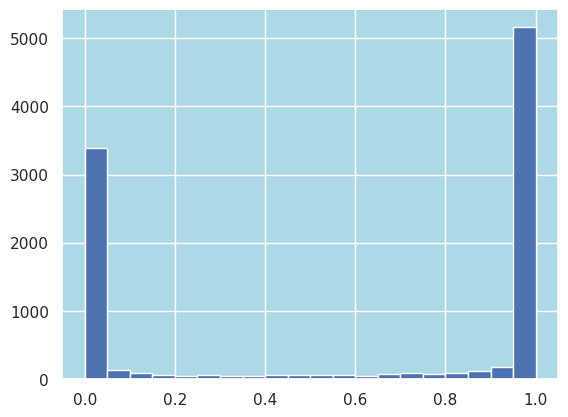

In [33]:
sns.set()
plt.hist(preds_bayes1, bins=20)
plt.gca().set_facecolor('lightblue')
min(preds_bayes1), max(preds_bayes1)

## <span style="color:darkred;">Prediction (EC2)</span>

In [34]:
train_code['EC1'] = df_train['EC1']
test_code['EC1'] = pipeline.predict(test_code)

In [35]:
test_code.loc[test_code["EC1"] >= 1, "EC1"] = 1

In [36]:
transformed = pd.DataFrame(QuantileTransformer(output_distribution='normal').fit_transform(train_code))

pipeline = make_pipeline(QuantileTransformer(output_distribution='normal'), GaussianNB())

pipeline.fit(train_code, target['EC2'])

Pipeline(steps=[('quantiletransformer',
                 QuantileTransformer(output_distribution='normal')),
                ('gaussiannb', GaussianNB())])

In [37]:
cross_val_score(pipeline, train_code, target['EC2'], scoring='roc_auc' , cv=7).mean()

0.5725046334833405

In [38]:
preds_bayes2 = pipeline.predict_proba(test_code)[:,1]
preds_bayes2

array([1.68879194e-18, 3.05059609e-17, 1.60360993e-18, ...,
       1.19090586e-14, 7.96181057e-06, 2.14197758e-14])

## <span style="color:darkred;">Prediction Histogram (EC2)</span>

(0.0, 1.0)

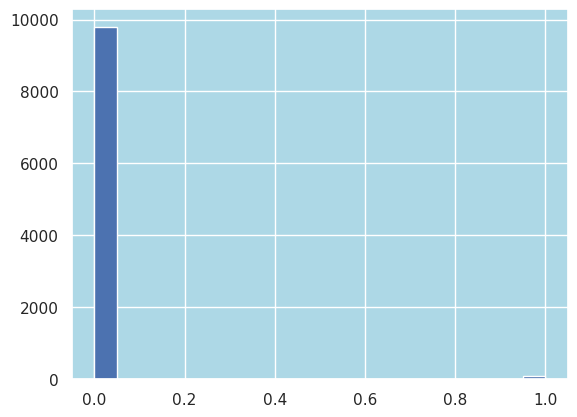

In [39]:
sns.set()
plt.hist(preds_bayes2, bins=20)
plt.gca().set_facecolor('lightblue')
min(preds_bayes2), max(preds_bayes2)

## <span style="color:darkred;">Submission - BAYES </span>

In [40]:
sub_bayes = df_sample.copy()
sub_bayes['EC1'] = preds_bayes1
sub_bayes['EC2'] = preds_bayes2
sub_bayes

,id,EC1,EC2
0,14838,8.529505e-03,1.688792e-18
1,14839,9.998500e-01,3.050596e-17
2,14840,9.999916e-01,1.603610e-18
3,14841,9.583674e-01,2.221068e-17
4,14842,1.608297e-18,4.363414e-17
...,...,...,...
9888,24726,4.656882e-01,1.009488e-18
9889,24727,9.997763e-01,9.318394e-18
9890,24728,3.805970e-07,1.190906e-14
9891,24729,4.772858e-25,7.961811e-06


In [41]:
sub_bayes.to_csv('submission.csv',index=False)
!ls

__notebook__.ipynb  submission.csv
